# TRƯỜNG HỢP CÓ TẤT CẢ HƯỚNG ĐI

## Huấn Luyện Trước 50 Để Khảo Sát

In [1]:
path = './logs/all_type_ways'
files = [
    f'{path}/resnet18_50epochs.txt',
    f'{path}/vgg16_50epochs.txt',
    f'{path}/custom_50epochs.txt'
]

In [2]:
import matplotlib.pyplot as plt

def read_file(file):
    trains = []
    vals = []
    with open(file, 'r') as file:
        for line in file:
            data = line.strip().split(' ')
            trains.append(float(data[5].replace(',', '')))
            vals.append(float(data[8].replace(',', '')))
    return trains, vals

def print_plot(files, max_col=3, ticks = []):
    num_files = len(files)
    num_rows = (num_files + max_col - 1) // max_col  # Tính số hàng cần thiết

    fig, axs = plt.subplots(num_rows, max_col, figsize=(5 * max_col, 4 * num_rows))
    axs = axs.flatten()  # Biến mảng 2D thành 1D để dễ index

    for idx, file in enumerate(files):
        trains, vals = read_file(file)
        title = file.split('/')[-1].split('.')[0]
        if idx in ticks:
            axs[idx].set_facecolor(ticks.get(idx, '#e6f7ff'))
        axs[idx].plot(trains, label='Train')
        axs[idx].plot(vals, label='Val')
        axs[idx].set_title(title)
        axs[idx].set_xlabel('Epoch')
        axs[idx].set_ylabel('Loss')
        axs[idx].legend()
        axs[idx].grid(True)
        axs[idx].set_ylim(0, 1)

    # Tắt các subplot dư nếu có
    for i in range(num_files, len(axs)):
        fig.delaxes(axs[i])

    plt.tight_layout()
    plt.show()

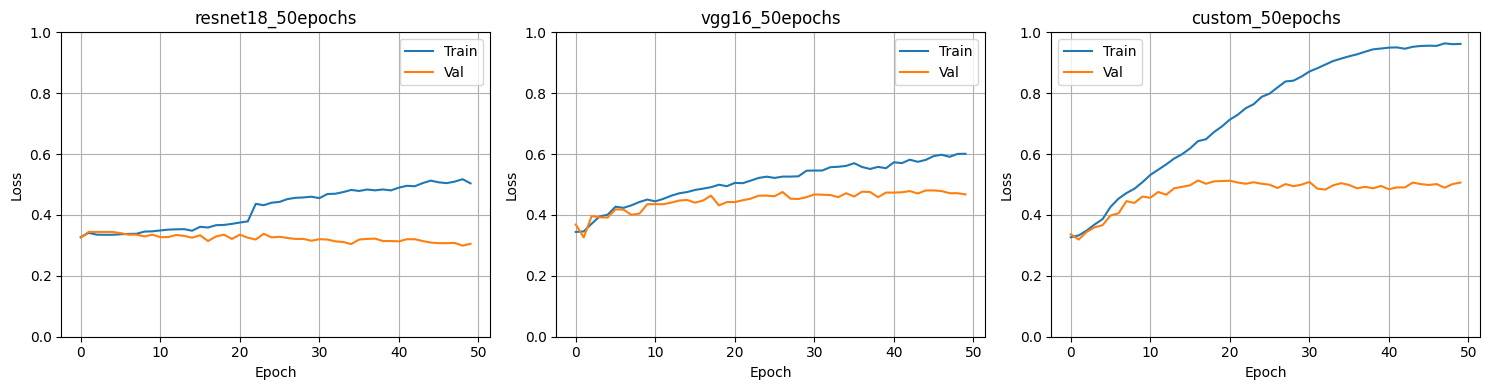

In [3]:
print_plot(files)

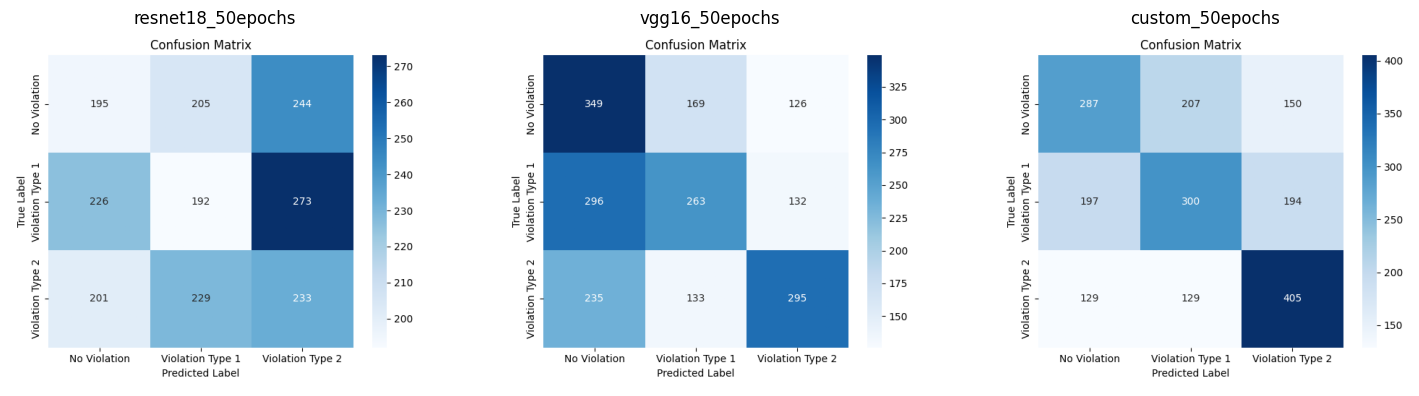

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

path = './logs/all_type_ways'
imgs = [
    f'{path}/resnet18_50epochs.png',
    f'{path}/vgg16_50epochs.png',
    f'{path}/custom_50epochs.png'
]

# Số cột trong lưới ảnh
max_col = 3
num_files = len(imgs)
num_rows = (num_files + max_col - 1) // max_col

fig, axs = plt.subplots(num_rows, max_col, figsize=(5 * max_col, 4 * num_rows))
axs = axs.flatten()

for idx, img_path in enumerate(imgs):
    img = mpimg.imread(img_path)
    axs[idx].imshow(img)
    axs[idx].set_title(os.path.basename(img_path).split('.')[0])
    axs[idx].axis('off')  # Ẩn trục tọa độ

# Ẩn các subplot dư nếu có
for i in range(num_files, len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

## Chạy Thực Nghiệm Các Trường Hợp Của Mô Hình Custom

In [39]:
data_file = {}
start = 0
path = './logs/all_type_ways'
with open(f'{path}/log_raw_update_custom.txt', 'r', encoding='utf-8') as file:
    data = file.read().split('\n')
    while True:
        name = data[start].split('-')[2]
        logs = data[start+1:start+31]
        data_file[name] = logs
        start += 32
        if start >= len(data):
            break

for key, val in data_file.items():
    with open(f'{path}/{key}.txt', 'w', encoding='utf-8') as file:
        for line in val[:-1]:
            file.write(line+'\n')
        file.write(val[-1])

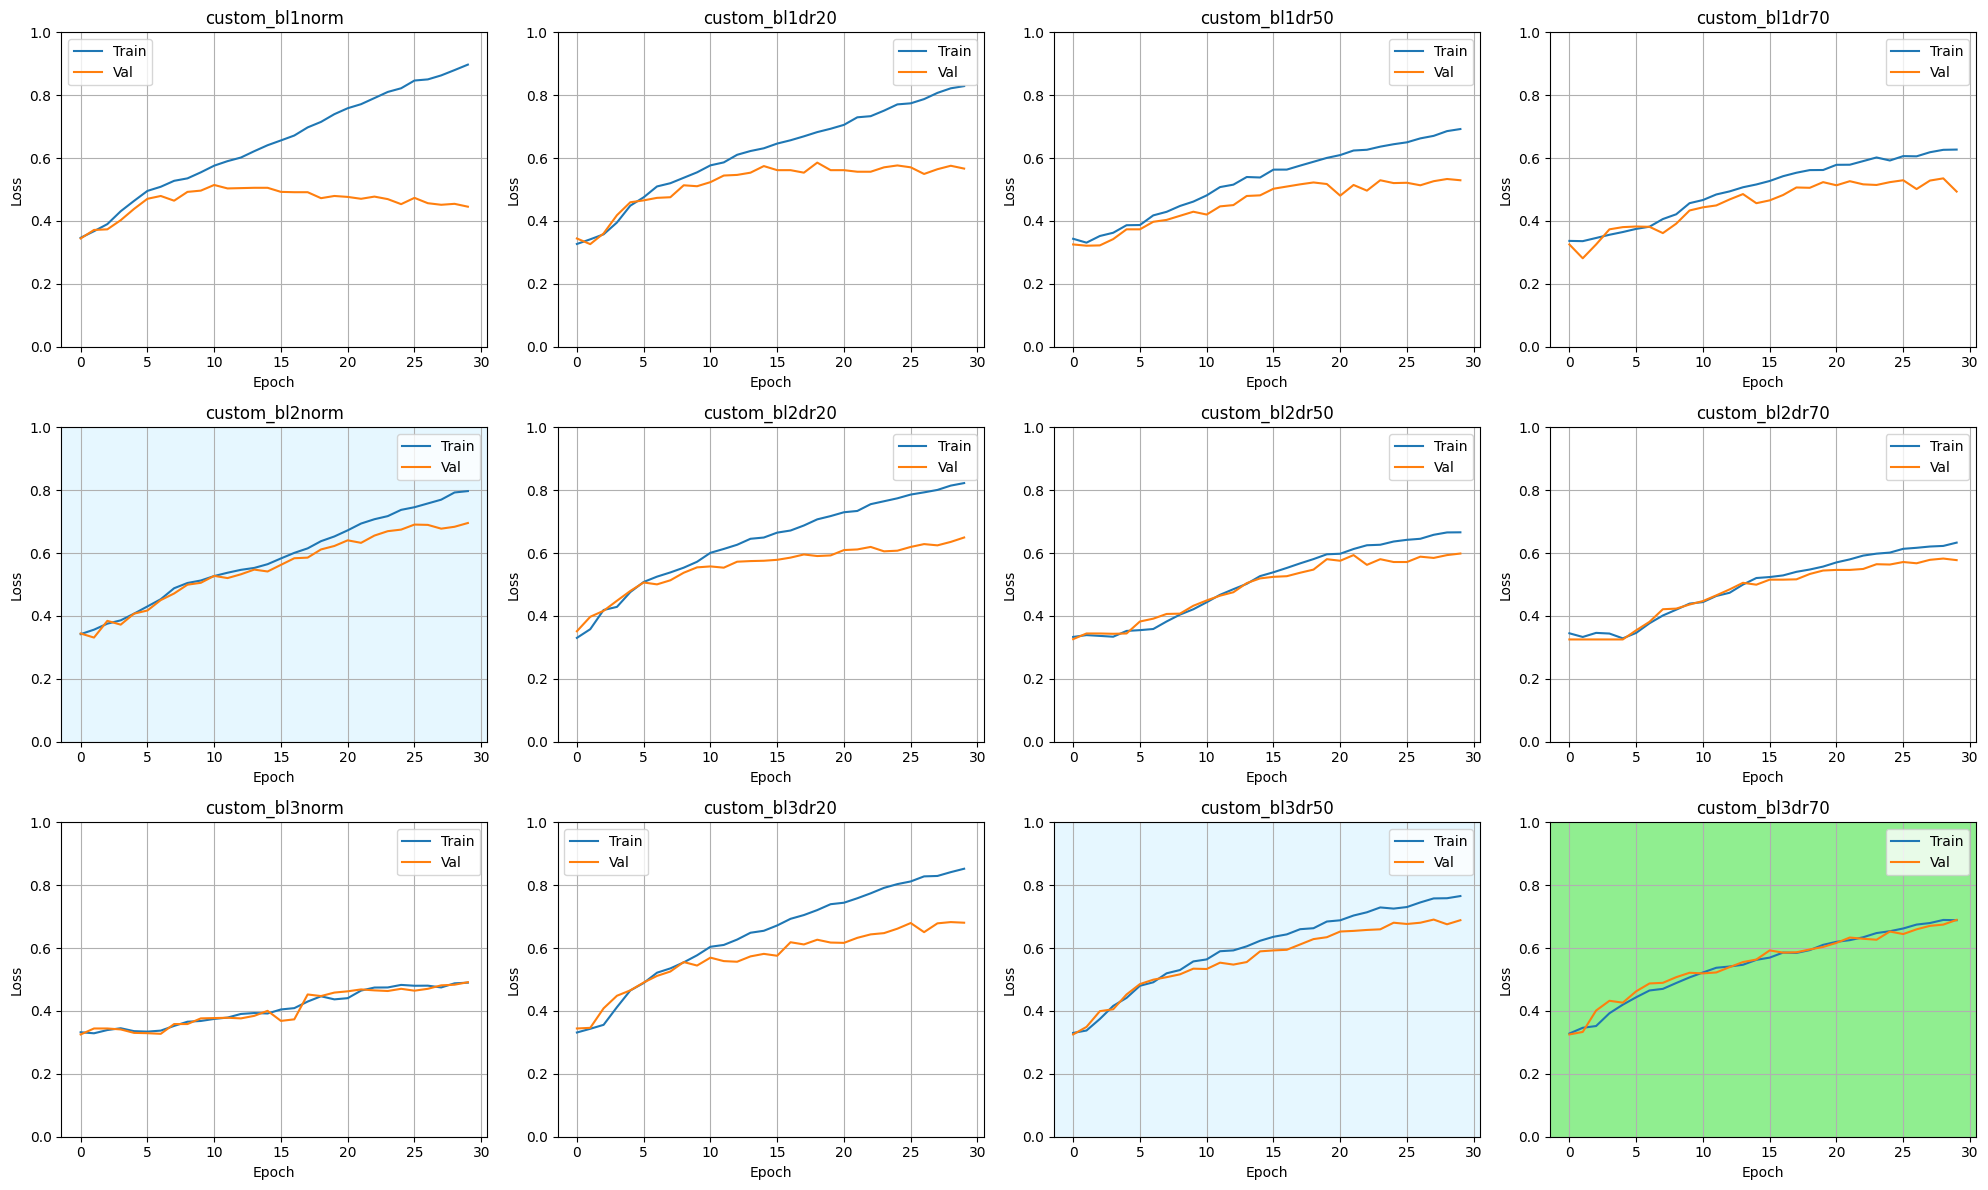

In [49]:
files = list([f'{path}/{f}.txt' for f in data_file.keys()])
print_plot(files, max_col=4, ticks = {4:'#e6f7ff', 10:'#e6f7ff', 11:'#90ee90'})

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models import resnet18, ResNet18_Weights

class TrafficCNN(nn.Module):
  def __init__(self, back_bone='vgg16', input_shape = (1, 64, 64), pretrained=True):
    super(TrafficCNN, self).__init__()

    # Tải Thông Số Backbone
    self.load_back_bone(back_bone, input_shape, pretrained)

    # Tự Động Tính Kích Thước Flatten
    with torch.no_grad():
      dummy_input = torch.zeros(1, *input_shape)
      out = self.features(dummy_input)
      self.flatten_dim = out.view(1, -1).size(1)

    # Thay đổi classifier để output 3 lớp
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(self.flatten_dim, 128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128, 3)  # output 3 lớp
    )

  def load_back_bone(self, back_bone='vgg16', input_shape = (1, 64, 64), pretrained=True):
    in_channels = input_shape[0]

    # Thông Số Custom
    if back_bone.startswith('custom'):
      self.get_permission(back_bone)
      self.get_custom(back_bone, in_channels)

    # Các Mô Hình Có Sẵn
    elif back_bone == 'vgg16':
        backbone = vgg16(weights=VGG16_Weights.DEFAULT if pretrained else None)
        backbone.features[0] = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.features = backbone.features
        if pretrained:
            for param in self.features.parameters():
                param.requires_grad = False

    elif back_bone == 'resnet18':
        backbone = resnet18(weights=ResNet18_Weights.DEFAULT if pretrained else None)
        if in_channels != 3:
            backbone.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.features = nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool,
            backbone.layer1,
            backbone.layer2,
            backbone.layer3,
            backbone.layer4
        )
        if pretrained:
            for param in self.features.parameters():
                param.requires_grad = False

  def get_permission(self, back_bone):
    configs = back_bone.split('_')
    check_list = ['norm', 'dr20', 'dr50', 'dr70']
    self.permission = {}
    if len(configs)>1:
        for config in configs[1:]:
          bl = config[:3]
          self.permission[bl] = {}
          for per in check_list:
            if per in config:
              self.permission[bl][per] = True


  def add_block(self, in_ch, out_ch, name):
    layers = [nn.Conv2d(in_ch, out_ch, 3, padding=1)]
    if name == 'bl1':
      layers = [nn.Conv2d(in_ch, out_ch, 5, padding=1)]
    conf = self.permission.get(name, {})
    if conf.get('norm', False):
        layers.append(nn.BatchNorm2d(out_ch))
    layers.append(nn.ReLU())
    if conf.get('dr20'):
        layers.append(nn.Dropout(0.2))
    elif conf.get('dr50'):
        layers.append(nn.Dropout(0.5))
    elif conf.get('dr70'):
        layers.append(nn.Dropout(0.7))
    layers.append(nn.MaxPool2d(2))
    return layers


  def get_custom(self, back_bone, in_channels):
    # Các Lớp Mặc Định
    ft_list = []
    # 1. Block 1
    in_ch = in_channels
    out_ch = 32
    name = 'bl1'
    ft_list += self.add_block(in_ch, out_ch, name)

    # 2. Block 2
    in_ch = 32
    out_ch = 64
    name = 'bl2'
    ft_list += self.add_block(in_ch, out_ch, name)

    # 3. Block 3
    in_ch = 64
    out_ch = 128
    name = 'bl3'
    ft_list += self.add_block(in_ch, out_ch, name)
    self.features = nn.Sequential(*ft_list)

  def __str__(self):
    string = f"Thông Số Flatten: {self.flatten_dim}"
    return string

  def forward(self, x):
    x = self.features(x)
    x = self.classifier(x)
    return x

In [7]:
from torchsummary import summary

model = TrafficCNN(back_bone='custom')
summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 62, 62]             832
              ReLU-2           [-1, 32, 62, 62]               0
         MaxPool2d-3           [-1, 32, 31, 31]               0
            Conv2d-4           [-1, 64, 31, 31]          18,496
              ReLU-5           [-1, 64, 31, 31]               0
         MaxPool2d-6           [-1, 64, 15, 15]               0
            Conv2d-7          [-1, 128, 15, 15]          73,856
              ReLU-8          [-1, 128, 15, 15]               0
         MaxPool2d-9            [-1, 128, 7, 7]               0
          Flatten-10                 [-1, 6272]               0
           Linear-11                  [-1, 128]         802,944
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   